# Compare attribution graph of benign and attacked image

- Show adversarial attacks on attribution graphs
- Attack image/class, compare graph against benign graph

## Import packages

In [4]:
# Set auto reload for python functions
%reload_ext autoreload
%autoreload 2

# Helper libraries
import cv2
import glob
import tqdm
import numpy as np
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt

# GoogLeNet
import lucid.modelzoo.vision_models as models

# Libraries provided by Massif project
import parse
import A_matrix
import I_matrix
import model_helper

print(tf.VERSION)

1.15.0


## Import GoogLeNet (InceptionV1) model

In [5]:
googlenet = models.InceptionV1()
googlenet.load_graphdef()

## Get constants and hyperparameters

In [8]:
args = parse.Args
arg_keys = [arg for arg in args.__dict__.keys() if '__' not in arg]

print('Constants and hyperparameters in args:')
print(arg_keys)

Constants and hyperparameters in args:
['gpu', 'batch_A', 'batch_I', 'layer', 'k_A', 'layer_sizes', 'layers', 'layer_blk_sizes', 'num_classes', 'img_width', 'img_height']


## Read input images

Benign image; class 102 (White wolf)


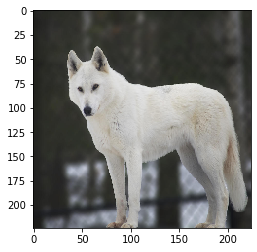

Attacked image; class 46 (Mexican_hairless)


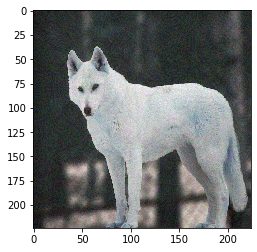

A sample image of class 46 (Mexican_hairless)


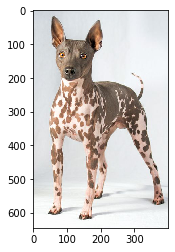

Output layer, neuron 46 has the highest value for the given attacked image


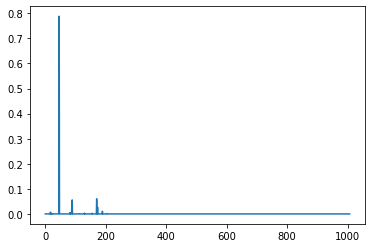

softmax value of neuron 46: 0.7883, 102: 0.0000


In [10]:
dirname = '../data/sample-images'
benign_image_path = '{}/{}'.format(dirname, 'white-wolf.jpg')
attacked_image_path = '{}/{}'.format(dirname, 'white-wolf-attacked-46.jpg')
attacked_class_image_path = '{}/{}'.format(dirname, 'american-hairless-sample.jpg')

print('Benign image; class 102 (White wolf)')
plt.figure()
raw_benign = plt.imread(benign_image_path)
raw_benign = cv2.resize(raw_benign, (args.img_width, args.img_height))
plt.imshow(raw_benign)
plt.show()

print('Attacked image; class 46 (Mexican_hairless)')
plt.figure()
raw_attacked = plt.imread(attacked_image_path)
raw_attacked = cv2.resize(raw_attacked, (args.img_width, args.img_height))
plt.imshow(raw_attacked)
plt.show()

print('A sample image of class 46 (Mexican_hairless)')
plt.figure()
attacked_class_sample = plt.imread(attacked_class_image_path)
plt.imshow(attacked_class_sample)
plt.show()

print('Output layer, neuron 46 has the highest value for the given attacked image')
y_eval, softmax_result = model_helper.get_predictions(googlenet, [raw_attacked])
plt.figure()
plt.plot(softmax_result[0])
plt.show()
print('softmax value of neuron 46: %.4lf, 102: %.4lf' % (softmax_result[0][46], softmax_result[0][102]))

## A_matrix: generate nodes

- A-matrix: shape of (#layers, #neurons)

### A_matrix of a **Benign** Image

In [11]:
As_benign = A_matrix.init_A_matrix_single_image(args)

In [12]:
act_scores_benign = model_helper.get_all_layers_activation_score(googlenet, [raw_benign], args.layers)

In [13]:
for layer in args.layers:
    As_benign[layer] = act_scores_benign[layer][0]

### A_matrix of a **Attacked** Image

In [16]:
As_attacked = A_matrix.init_A_matrix_single_image(args)

In [17]:
act_scores_attacked = model_helper.get_all_layers_activation_score(googlenet, [raw_attacked], args.layers)

In [18]:
for layer in args.layers:
    As_attacked[layer] = act_scores_attacked[layer][0]

## I_matrix: generate edges

- I_matrix for a given layer: (#neurons, #previous_neurons)

### I_matrix of the **Benign** Image

In [19]:
Is_benign = {}
for layer in args.layers:
    if layer == 'mixed3a':
        continue
    for i in range(6):
        Is_benign['{}_{}'.format(layer, i)] = [[]]

In [20]:
Is_benign = I_matrix.gen_I_matrix(args, {0: Is_benign}, [raw_benign], googlenet)

### I_matrix of the **Attacked** Image

In [21]:
Is_attacked = {}
for layer in args.layers:
    if layer == 'mixed3a':
        continue
    for i in range(6):
        Is_attacked['{}_{}'.format(layer, i)] = [[]]

In [22]:
Is_attacked = I_matrix.gen_I_matrix(args, {0: Is_attacked}, [raw_attacked], googlenet)

## Generate full graph

### Generate full graph of the **Benign** image

In [23]:
I_benign = Is_benign[0]
print(I_benign['mixed5a_0'].shape)
print(I_benign['mixed5a_1'].shape)
print(I_benign['mixed5a_2'].shape)
print(I_benign['mixed5a_3'].shape)
print(I_benign['mixed5a_4'].shape)
print(I_benign['mixed5a_5'].shape)

(256, 832)
(320, 160)
(128, 48)
(128, 832)
(160, 832)
(48, 832)


### Generate full graph of the **Attacked** image

In [24]:
'''
Massif: Project title
File name: A_matrix.py
Author: Haekyu Park
Date: Nov 13, 2019

This code generates attribution graph.
'''

import networkx as nx
import model_helper
from time import time

def gen_full_graph(args, A, I):

    # Initialize an undirected graph
    G = nx.Graph()

    # Get layers
    layers = args.layers
    layer_sizes = args.layer_sizes

    # Add nodes from A

    # Add edges from I
    for layer_idx, layer in enumerate(layers[::-1][:-1]):

        # Get previous layer
        prev_layer = layers[::-1][layer_idx + 1]

        # For all neurons in the currrent layer
        for neuron in range(layer_sizes[layer]):

            # Make source node id
            src = gen_node_name(layer, neuron)

            # Get the block the neuron belongs to
            blk = model_helper.get_blk_of_neuron(args, layer, neuron)
            layer_key = '{}_{}'.format(layer, blk)
            neuron_th_in_blk = neuron - model_helper.get_num_neurons_in_prev_blks(args, layer, neuron)

            # Get the influences for the block
            I_blk = I[layer_key]
            
            # Get the number of previous neurons
            num_prev_neurons = I_blk.shape[-1]

            # If the neuron is connected to an intermediate layer
            if blk in [1, 2]:
                
                # Get I-matrix between the intermediate layer and prev_layer
                if blk == 1:
                    inter_layer_key = '{}_{}'.format(layer, 4)
                elif blk == 2:
                    inter_layer_key = '{}_{}'.format(layer, 5)
                I_inter = I[inter_layer_key] 
                
                # Get the number of previous neurons
                num_prev_prev_neurons = I_inter.shape[-1]
                
                # Get all possible edge weights between 
                #  the neuron in current layer and ones in prev_layer
                neuron_edges = {}
                for prev_neuron in range(num_prev_neurons):
                    inf = I_blk[neuron_th_in_blk][prev_neuron]
                    for prev_prev_neuron in range(num_prev_prev_neurons):
                        prev_inf = I_inter[prev_neuron][prev_prev_neuron]
                        if prev_prev_neuron not in neuron_edges:
                            neuron_edges[prev_prev_neuron] = []
                        neuron_edges[prev_prev_neuron].append(min(inf, prev_inf))
                        
                # For given a neuron in the prev_layer,
                #  choose only one weight that has the maximum weights
                #  between the previous neuron and the current neuron
                for prev_prev_neuron in neuron_edges:
                    max_inf = max(neuron_edges[prev_prev_neuron])
                    tgt = gen_node_name(prev_layer, prev_prev_neuron)
                    G.add_edge(src, tgt, weight=max_inf)
                    
            # If the neuron is directly connected to the previous layer
            elif blk in [0, 3]:
                num_prev_neurons = I_blk.shape[-1]
                for prev_neuron in range(num_prev_neurons):
                    inf = I_blk[neuron_th_in_blk][prev_neuron]
                    tgt = gen_node_name(prev_layer, prev_neuron)
                    G.add_edge(src, tgt, weight=inf)
            else:
                err_msg = 'ERROR: Cannot get the block of '
                err_msg += 'neuron ({}) in ({}).'.format(neuron, layer)
                err_msg += 'The block is expected to be in [0, 1, 2, 3], '
                err_msg += 'but {} is given.'.format(blk)
                print(err_msg)
        toc = time()
        print(layer, '%.2lf' % (toc - tic))

    return G


def gen_node_name(layer, neuron):
    return layer + '-' + str(neuron)

In [25]:
G = gen_full_graph(args, As_benign, I_benign)

mixed5a 28.58


KeyboardInterrupt: 

## Compare the results of benign and attacked images -- ex) layer = mixed4c

In [ ]:
layer = 'mixed4d'
benign_activations = As_benign[layer]
attacked_activations = As_attacked[layer]

diff = benign_activations - attacked_activations
abs_diff = np.abs(diff)
sorted_neurons_benign = np.argsort(benign_activations)
sorted_neurons_attacked = np.argsort(attacked_activations)
sorted_neurons_diff = np.argsort(diff)

In [ ]:
print('Compare activation, neurons sorted by benign')
print('Ignore the x-axis numbers; they are not neurons exactly.')
plt.plot(benign_activations[sorted_neurons_benign])
plt.plot(attacked_activations[sorted_neurons_benign])
plt.plot(diff[sorted_neurons_benign])
plt.legend(['Benign', 'Attacked', 'Difference (Benign - Attacked)'])
plt.xlabel('Neurons sorted by benign')
plt.ylabel('Activation')
plt.show()

In [ ]:
print('Compare activation, neurons sorted by attacked')
print('Ignore the x-axis numbers; they are not neurons exactly.')
plt.plot(benign_activations[sorted_neurons_attacked])
plt.plot(attacked_activations[sorted_neurons_attacked])
plt.plot(diff[sorted_neurons_attacked])
plt.legend(['Benign', 'Attacked', 'Difference (Benign - Attacked)'])
plt.xlabel('Neurons sorted by attacked')
plt.ylabel('Activation')
plt.show()

In [ ]:
print('Compare activation, neurons sorted by difference between attacked and benign')
print('Ignore the x-axis numbers; they are not neurons exactly.')

plt.figure()
reverse_sorted_neurons = sorted_neurons_diff[::-1]
reverse_sorted_activation = np.sort(diff)[::-1]
plt.plot(reverse_sorted_activation)
plt.ylabel("activation difference")
plt.xlabel('Neurons sorted by difference between attacked and benign')
plt.show()
print('<--- More benign side      ...     More attacked side --->')

## Find out neurons influenced by the attack
- The neurons are one of the **highly** activated ones for **attacked** image and **misclassified** class.
- The neurons are one of the **barely** activated ones for **benign** image and **original** class.

In [ ]:
topk = 10
top_standard = 0.1 # 10%
low_standard = 0.3 # 30%

num_total_neurons = len(sorted_neurons_attacked)
top_rank_thresold = num_total_neurons * top_standard
low_rank_threshold = num_total_neurons * low_standard

In [ ]:
rank_of_neurons_attacked = sorted_neurons_attacked[::-1]
rank_of_neurons_benign = sorted_neurons_benign[::-1]

got_activated_neurons, no_longer_activated_neurons, both_activated_neurons = [], [], []
for neuron in rank_of_neurons_attacked:
    
    rank_in_attacked = np.argwhere(rank_of_neurons_attacked == neuron)
    rank_in_benign = np.argwhere(rank_of_neurons_benign == neuron)
    
    is_responsive_to_attacked = rank_in_attacked < top_rank_thresold
    is_responsive_to_attacked = is_responsive_to_attacked[0][0]
    
    is_non_responsive_to_benign = rank_in_benign > low_rank_threshold
    is_non_responsive_to_benign = is_non_responsive_to_benign[0][0]
    
    is_non_responsive_to_attacked = rank_in_attacked > low_rank_threshold
    is_non_responsive_to_attacked = is_non_responsive_to_attacked[0][0]
    
    is_responsive_to_benign = rank_in_benign < top_rank_thresold
    is_responsive_to_benign = is_responsive_to_benign[0][0]
    
    if is_responsive_to_attacked and is_non_responsive_to_benign:
        got_activated_neurons.append(neuron)
    
    if is_non_responsive_to_attacked and is_responsive_to_benign:
        no_longer_activated_neurons.append(neuron)
    
    if is_responsive_to_attacked and is_responsive_to_benign:
        both_activated_neurons.append(neuron)

In [ ]:
print('Look into neurons that got activatied by the attacked image, while was idle by benign image.')
print('The attacked image newly got the following features to fool the model.')
print('Neurons:', got_activated_neurons)
print()

vis_dirpath = '/Users/haekyu/data/summit/summit-data/data/feature-vis'
for neuron in got_activated_neurons:
    
    rank_in_attacked = np.argwhere(rank_of_neurons_attacked == neuron)
    rank_in_benign = np.argwhere(rank_of_neurons_benign == neuron)
    top_percent_in_attacked = 100 * rank_in_attacked / num_total_neurons
    top_percent_in_benign = 100 * rank_in_benign / num_total_neurons
    
    print('{}-{}'.format(layer, neuron))
    print('Top %.2lf%% in benign (White wolf) --> top %.2lf%% in attacked (Mexican hairless)' % (top_percent_in_benign, top_percent_in_attacked))
    
    plt.figure()
    
    # Feature vis
    plt.subplot(231)
    feature_vis_path = '{}/channel/{}-{}-channel.jpg'.format(vis_dirpath, layer, neuron)
    feature_vis = plt.imread(feature_vis_path)
    plt.axis('off')
    plt.imshow(feature_vis)
    
    # Example patch 0
    plt.subplot(234)
    ex0_path = '{}/dataset-p/{}-{}-dataset-p-0.jpg'.format(vis_dirpath, layer, neuron)
    ex0 = plt.imread(ex0_path)
    plt.axis('off')
    plt.imshow(ex0)
    
    # Example patch 1
    plt.subplot(232)
    ex1_path = '{}/dataset-p/{}-{}-dataset-p-1.jpg'.format(vis_dirpath, layer, neuron)
    ex1 = plt.imread(ex1_path)
    plt.axis('off')
    plt.imshow(ex1)
    
    # Example patch 2
    plt.subplot(235)
    ex2_path = '{}/dataset-p/{}-{}-dataset-p-2.jpg'.format(vis_dirpath, layer, neuron)
    ex2 = plt.imread(ex2_path)
    plt.axis('off')
    plt.imshow(ex2)
    
    # Example patch 3
    plt.subplot(233)
    ex3_path = '{}/dataset-p/{}-{}-dataset-p-3.jpg'.format(vis_dirpath, layer, neuron)
    ex3 = plt.imread(ex3_path)
    plt.axis('off')
    plt.imshow(ex3)

    # Example patch 4
    plt.subplot(236)
    ex4_path = '{}/dataset-p/{}-{}-dataset-p-4.jpg'.format(vis_dirpath, layer, neuron)
    ex4 = plt.imread(ex4_path)
    plt.axis('off')
    plt.imshow(ex4)
    
    plt.show()


In [ ]:
print('Look into neurons that are no longer activated in attacked image, while was very activated by benign image.')
print('The attacked images lose the following features.')
print('Neurons:', got_activated_neurons)
print()

vis_dirpath = '/Users/haekyu/data/summit/summit-data/data/feature-vis'
for neuron in no_longer_activated_neurons:
    
    rank_in_attacked = np.argwhere(rank_of_neurons_attacked == neuron)
    rank_in_benign = np.argwhere(rank_of_neurons_benign == neuron)
    top_percent_in_attacked = 100 * rank_in_attacked / num_total_neurons
    top_percent_in_benign = 100 * rank_in_benign / num_total_neurons
    
    print('{}-{}'.format(layer, neuron))
    print('Top %.2lf%% in benign (White wolf) --> top %.2lf%% in attacked (Mexican hairless)' % (top_percent_in_benign, top_percent_in_attacked))
    
    plt.figure()
    
    # Feature vis
    plt.subplot(231)
    feature_vis_path = '{}/channel/{}-{}-channel.jpg'.format(vis_dirpath, layer, neuron)
    feature_vis = plt.imread(feature_vis_path)
    plt.axis('off')
    plt.imshow(feature_vis)
    
    # Example patch 0
    plt.subplot(234)
    ex0_path = '{}/dataset-p/{}-{}-dataset-p-0.jpg'.format(vis_dirpath, layer, neuron)
    ex0 = plt.imread(ex0_path)
    plt.axis('off')
    plt.imshow(ex0)
    
    # Example patch 1
    plt.subplot(232)
    ex1_path = '{}/dataset-p/{}-{}-dataset-p-1.jpg'.format(vis_dirpath, layer, neuron)
    ex1 = plt.imread(ex1_path)
    plt.axis('off')
    plt.imshow(ex1)
    
    # Example patch 2
    plt.subplot(235)
    ex2_path = '{}/dataset-p/{}-{}-dataset-p-2.jpg'.format(vis_dirpath, layer, neuron)
    ex2 = plt.imread(ex2_path)
    plt.axis('off')
    plt.imshow(ex2)
    
    # Example patch 3
    plt.subplot(233)
    ex3_path = '{}/dataset-p/{}-{}-dataset-p-3.jpg'.format(vis_dirpath, layer, neuron)
    ex3 = plt.imread(ex3_path)
    plt.axis('off')
    plt.imshow(ex3)

    # Example patch 4
    plt.subplot(236)
    ex4_path = '{}/dataset-p/{}-{}-dataset-p-4.jpg'.format(vis_dirpath, layer, neuron)
    ex4 = plt.imread(ex4_path)
    plt.axis('off')
    plt.imshow(ex4)
    
    plt.show()


In [ ]:
print('Look into neurons that are no longer activated in attacked image, while was very activated by benign image.')
print('The attacked images lose the following features.')
print('Neurons:', both_activated_neurons[:topk])
print()

vis_dirpath = '/Users/haekyu/data/summit/summit-data/data/feature-vis'
for neuron in both_activated_neurons[:topk]:
    
    rank_in_attacked = np.argwhere(rank_of_neurons_attacked == neuron)
    rank_in_benign = np.argwhere(rank_of_neurons_benign == neuron)
    top_percent_in_attacked = 100 * rank_in_attacked / num_total_neurons
    top_percent_in_benign = 100 * rank_in_benign / num_total_neurons
    
    print('{}-{}'.format(layer, neuron))
    print('Top %.2lf%% in benign (White wolf) --> top %.2lf%% in attacked (Mexican hairless)' % (top_percent_in_benign, top_percent_in_attacked))
    
    plt.figure()
    
    # Feature vis
    plt.subplot(231)
    feature_vis_path = '{}/channel/{}-{}-channel.jpg'.format(vis_dirpath, layer, neuron)
    feature_vis = plt.imread(feature_vis_path)
    plt.axis('off')
    plt.imshow(feature_vis)
    
    # Example patch 0
    plt.subplot(234)
    ex0_path = '{}/dataset-p/{}-{}-dataset-p-0.jpg'.format(vis_dirpath, layer, neuron)
    ex0 = plt.imread(ex0_path)
    plt.axis('off')
    plt.imshow(ex0)
    
    # Example patch 1
    plt.subplot(232)
    ex1_path = '{}/dataset-p/{}-{}-dataset-p-1.jpg'.format(vis_dirpath, layer, neuron)
    ex1 = plt.imread(ex1_path)
    plt.axis('off')
    plt.imshow(ex1)
    
    # Example patch 2
    plt.subplot(235)
    ex2_path = '{}/dataset-p/{}-{}-dataset-p-2.jpg'.format(vis_dirpath, layer, neuron)
    ex2 = plt.imread(ex2_path)
    plt.axis('off')
    plt.imshow(ex2)
    
    # Example patch 3
    plt.subplot(233)
    ex3_path = '{}/dataset-p/{}-{}-dataset-p-3.jpg'.format(vis_dirpath, layer, neuron)
    ex3 = plt.imread(ex3_path)
    plt.axis('off')
    plt.imshow(ex3)

    # Example patch 4
    plt.subplot(236)
    ex4_path = '{}/dataset-p/{}-{}-dataset-p-4.jpg'.format(vis_dirpath, layer, neuron)
    ex4 = plt.imread(ex4_path)
    plt.axis('off')
    plt.imshow(ex4)
    
    plt.show()


In [ ]:
neuron = got_activated_neurons[0]
prev_layer = args.layers[args.layers.index(layer) - 1]

with tf.Graph().as_default():
    
    # Define activation render
    t_input = tf.placeholder(tf.float32, [None, 224, 224, 3])
    googlenet.import_graph(t_input)
    
    t_w0, t_w1, t_w2, t_w3, t_w4, t_w5 = model_helper.get_weight_tensors(layer)
    t_a0, t_a1, t_a2 = model_helper.get_intermediate_layer_tensors(prev_layer, layer)
    t_curr_act_map = tf.get_default_graph().get_tensor_by_name('import/%s:0' % layer)
    
    blk = model_helper.get_blk_of_neuron(args, layer, neuron)
    
    if blk == 0:
        t_a = t_a0
        t_w = t_w0
        prev_name = prev_layer
    elif blk == 1:
        t_a = t_a1
        t_w = t_w2
        prev_name = '%s_3x3_bottleneck:0' % layer
    elif blk == 2:
        t_a = t_a2
        t_w = t_w4
        prev_name = '%s_5x5_bottleneck:0' % layer
    elif blk == 3:
        t_a = t_a0
        t_w = t_w5
        prev_name = prev_layer
    
    with tf.Session() as sess:
        prev_act_maps, weight_filter, curr_act_maps = sess.run([t_a, t_w, t_curr_act_map], feed_dict={t_input: [raw_attacked]})

In [ ]:
prev_act_map = prev_act_maps[0]
curr_act_map = curr_act_maps[0]
prev_act_map_grayscale = np.average(prev_act_map, axis=2)
curr_act_map_grayscale = np.average(curr_act_map, axis=2)

In [ ]:
print('Activation map in the previous layer ({})'.format(prev_name))

plt.figure()

# Attacked image
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(raw_attacked)
plt.text(25, -10, 'Attacked image')

# Previous layer's activation map
prev_act_map_grayscale = np.average(prev_act_map, axis=2)
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(prev_act_map_grayscale)
plt.text(0, -2.8, 'Activation map avg')
plt.text(1, -1.2, 'in previous layer')

# Example patch 0
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(curr_act_map_grayscale)
plt.text(0, -2.8, 'Activation map avg')
plt.text(1, -1.0, 'in current layer')

plt.show()

In [ ]:
neuron = got_activated_neurons[0]
neuron_th = neuron
for b in range(blk - 1, -1, -1):
    b_size = args.layer_blk_sizes['{}_{}'.format(layer, b)]
    neuron_th -= b_size
    
print('{} in {}, {} in block {}'.format(neuron, layer, neuron_th, blk))

num_prev_neurons = prev_act_map.shape[-1]
num_rows = num_prev_neurons

plt.figure(figsize=(10, 200))
for prev_neuron in range(num_prev_neurons):
    if prev_neuron + 1 == num_rows:
        break
        
    prev_neuron_act_map = prev_act_map[:, :, prev_neuron]
    plt.subplot(num_rows, 3, 3 * (prev_neuron + 1) + 1)
    plt.axis('off')
    plt.imshow(prev_neuron_act_map, cmap='gray')
    plt.text(0, -2, 'prev_{}'.format(prev_neuron))
    plt.colorbar()
    
    w = weight_filter[:, :, prev_neuron, neuron_th]
    plt.subplot(num_rows, 3, 3 * (prev_neuron + 1) + 2)
    plt.axis('off')
    plt.imshow(w, cmap='gray')
    plt.text(0, -2, 'filter_{}'.format(prev_neuron))
    plt.colorbar()
    
    f = cv2.filter2D(prev_neuron_act_map, -1, w)
    plt.subplot(num_rows, 3, 3 * (prev_neuron + 1) + 3)
    plt.axis('off')
    plt.imshow(f, cmap='gray')
    plt.text(0, -2, 'depth_{}'.format(prev_neuron))
    plt.colorbar()
    
plt.show()